In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Data Preprocessing

In [2]:
def convert_to_numeric(x):
    if isinstance(x, str):
        return float(x.replace(",", ""))
    return float(x)

def get_bidding_timestamp(row):
    """
    encodes the date to be relative to the first bidding exercise
    for the convenience of merging time shifted data
    """
    year = row["Announcement Date"].year * 24
    month = (row["Announcement Date"].month - 1) * 2
    sub_month = row["Bidding Exercise"].split()[2]
    sub_month = 0 if sub_month == "First" else 1
    return year + month + sub_month
    

### Bidding results

In [3]:
category_map = {
    "Cat A (Cars up to 1600cc and 97kW)": "A",
    "Cat B (Cars above 1600cc or 97kW)": "B"
}

numerical_columns = [
    "Year", 
    "Quota", 
    "Total Bids Received", 
    "Number of Successful Bids", 
    "Quota Premium",
    "Bidding Timestamp"
]
bidding_results_df = pd.read_csv("data/bidding-results.csv")

bidding_results_df["Announcement Date"] = pd.to_datetime(
    bidding_results_df["Announcement Date"], format="%d/%m/%y"
)
bidding_results_df = bidding_results_df.sort_values(by=["Announcement Date"]).reset_index(drop=True)

bidding_results_df["Category"] = bidding_results_df["Category"].apply(
    lambda x: category_map.get(x, np.nan)
)
bidding_results_df =  bidding_results_df.dropna()

bidding_results_df["Bidding Timestamp"] = bidding_results_df.apply(
    get_bidding_timestamp, axis=1
)
bidding_results_df["Quota Premium"] = bidding_results_df["Quota Premium"].apply(
    lambda x: x.replace("$", "")
)
bidding_results_df[numerical_columns] = bidding_results_df[numerical_columns].applymap(convert_to_numeric)

date_range = (
    bidding_results_df["Announcement Date"].min(),
    bidding_results_df["Announcement Date"].max()
)

bidding_results_df

,Bidding Exercise,Announcement Date,Year,Category,Quota,Quota Premium,Total Bids Received,Number of Successful Bids,Bidding Timestamp
1,April 2002 First Open Bidding Exercise,2002-04-01,2002.0,A,1110.0,37201.0,2484.0,1092.0,48054.0
2,April 2002 First Open Bidding Exercise,2002-04-01,2002.0,B,558.0,39509.0,1119.0,551.0,48054.0
5,April 2002 Second Open Bidding Exercise,2002-04-15,2002.0,A,1149.0,36000.0,1890.0,1148.0,48055.0
6,April 2002 Second Open Bidding Exercise,2002-04-15,2002.0,B,553.0,42101.0,1104.0,553.0,48055.0
12,May 2002 First Open Bidding Exercise,2002-05-01,2002.0,B,560.0,40001.0,1043.0,518.0,48056.0
...,...,...,...,...,...,...,...,...,...
2349,January 2022 Second Open Bidding Exercise,2022-01-19,2022.0,A,531.0,57898.0,711.0,526.0,48529.0
2350,February 2022 First Open Bidding Exercise,2022-02-09,2022.0,A,542.0,60761.0,819.0,542.0,48530.0
2351,February 2022 First Open Bidding Exercise,2022-02-09,2022.0,B,550.0,86102.0,865.0,549.0,48530.0
2358,February 2022 Second Open Bidding Exercise,2022-02-23,2022.0,B,559.0,93590.0,939.0,554.0,48531.0


### Supplementary data

Includes:
- Vehicle population data
- Registration data
- Deregistration data
- Transport CPI

In [4]:
def read_df(path, col_name, split_category=True):
    df = pd.read_csv(path).T
    
    if split_category:
        df = df.iloc[:, [1,2]]
    else:
        df = df.iloc[:, [1]]
    
    df = df[1:]
    df.index = pd.to_datetime(df.index)
    df.index.name = "Month"
    df = df.sort_index()
    df = df.applymap(convert_to_numeric)

    if split_category:
        df.columns = pd.MultiIndex.from_arrays(
            [(col_name, col_name), ("A", "B")], names=(None, "Category")
        )
        df = df.stack()
    else:
        df.columns = [col_name]
    
    df = df.reset_index()
    return df

population_df = read_df("data/motor-vehicle-population.csv", "Vehicle Population")
registration_df = read_df("data/new-registration.csv", "Registration")
deregistration_df = read_df("data/deregistration.csv", "Deregistration")
CPI_df = read_df("data/CPI-transport.csv", "Transport CPI", split_category=False)

supplementary_df = pd.merge(
    population_df,
    pd.merge(registration_df, deregistration_df, how="outer", on=["Month", "Category"]),
    how="outer",
    on=["Month", "Category"]
)

supplementary_df["Population Change"] = (
    supplementary_df["Registration"] - supplementary_df["Deregistration"]
)

supplementary_df = pd.merge(supplementary_df, CPI_df, how="outer", on=["Month"])

supplementary_df["Bidding Timestamp"] = supplementary_df["Month"].apply(
    lambda x: x.year * 24 + (x.month - 1) * 2
)
supplementary_df_copy = supplementary_df.copy()
supplementary_df_copy["Bidding Timestamp"] = supplementary_df_copy["Bidding Timestamp"] + 1
supplementary_df = pd.concat([supplementary_df, supplementary_df_copy], axis=0, ignore_index=True)
supplementary_df = supplementary_df.sort_values(by=["Bidding Timestamp"])
supplementary_df = supplementary_df.drop(columns=["Month"])

supplementary_df = supplementary_df.dropna(subset=["Category"])
supplementary_df = supplementary_df.reset_index(drop=True)
supplementary_df

,Category,Vehicle Population,Registration,Deregistration,Population Change,Transport CPI,Bidding Timestamp
0,A,219348.0,1365.0,1308.0,57.0,58.3,47768
1,B,49128.0,213.0,157.0,56.0,58.3,47768
2,B,49128.0,213.0,157.0,56.0,58.3,47769
3,A,219348.0,1365.0,1308.0,57.0,58.3,47769
4,A,219746.0,1442.0,1044.0,398.0,58.1,47770
...,...,...,...,...,...,...,...
1519,B,323174.0,1696.0,1167.0,529.0,115.7,48527
1520,B,323620.0,1645.0,1199.0,446.0,115.8,48528
1521,A,321432.0,1315.0,1383.0,-68.0,115.8,48528
1522,B,323620.0,1645.0,1199.0,446.0,115.8,48529


### Combined Data

In [5]:
combined_df = pd.merge(bidding_results_df, supplementary_df, how="outer", on=["Bidding Timestamp", "Category"])
combined_df = combined_df.sort_values(by=["Bidding Timestamp"])
combined_df = combined_df.reset_index(drop=True)

combined_df.to_csv("./data/combined_df.csv", index=False)
combined_df

,Bidding Exercise,Announcement Date,Year,Category,Quota,Quota Premium,Total Bids Received,Number of Successful Bids,Bidding Timestamp,Vehicle Population,Registration,Deregistration,Population Change,Transport CPI
0,NaN,NaT,NaN,B,NaN,NaN,NaN,NaN,47768.0,49128.0,213.0,157.0,56.0,58.3
1,NaN,NaT,NaN,A,NaN,NaN,NaN,NaN,47768.0,219348.0,1365.0,1308.0,57.0,58.3
2,NaN,NaT,NaN,B,NaN,NaN,NaN,NaN,47769.0,49128.0,213.0,157.0,56.0,58.3
3,NaN,NaT,NaN,A,NaN,NaN,NaN,NaN,47769.0,219348.0,1365.0,1308.0,57.0,58.3
4,NaN,NaT,NaN,A,NaN,NaN,NaN,NaN,47770.0,219746.0,1442.0,1044.0,398.0,58.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,January 2022 Second Open Bidding Exercise,2022-01-19,2022.0,A,531.0,57898.0,711.0,526.0,48529.0,321432.0,1315.0,1383.0,-68.0,115.8
1524,February 2022 First Open Bidding Exercise,2022-02-09,2022.0,A,542.0,60761.0,819.0,542.0,48530.0,NaN,NaN,NaN,NaN,NaN
1525,February 2022 First Open Bidding Exercise,2022-02-09,2022.0,B,550.0,86102.0,865.0,549.0,48530.0,NaN,NaN,NaN,NaN,NaN
1526,February 2022 Second Open Bidding Exercise,2022-02-23,2022.0,A,536.0,63000.0,876.0,524.0,48531.0,NaN,NaN,NaN,NaN,NaN


# Exploration

### Trend of different features across time

Text(0.5, 1.0, 'Transport CPI over Time')

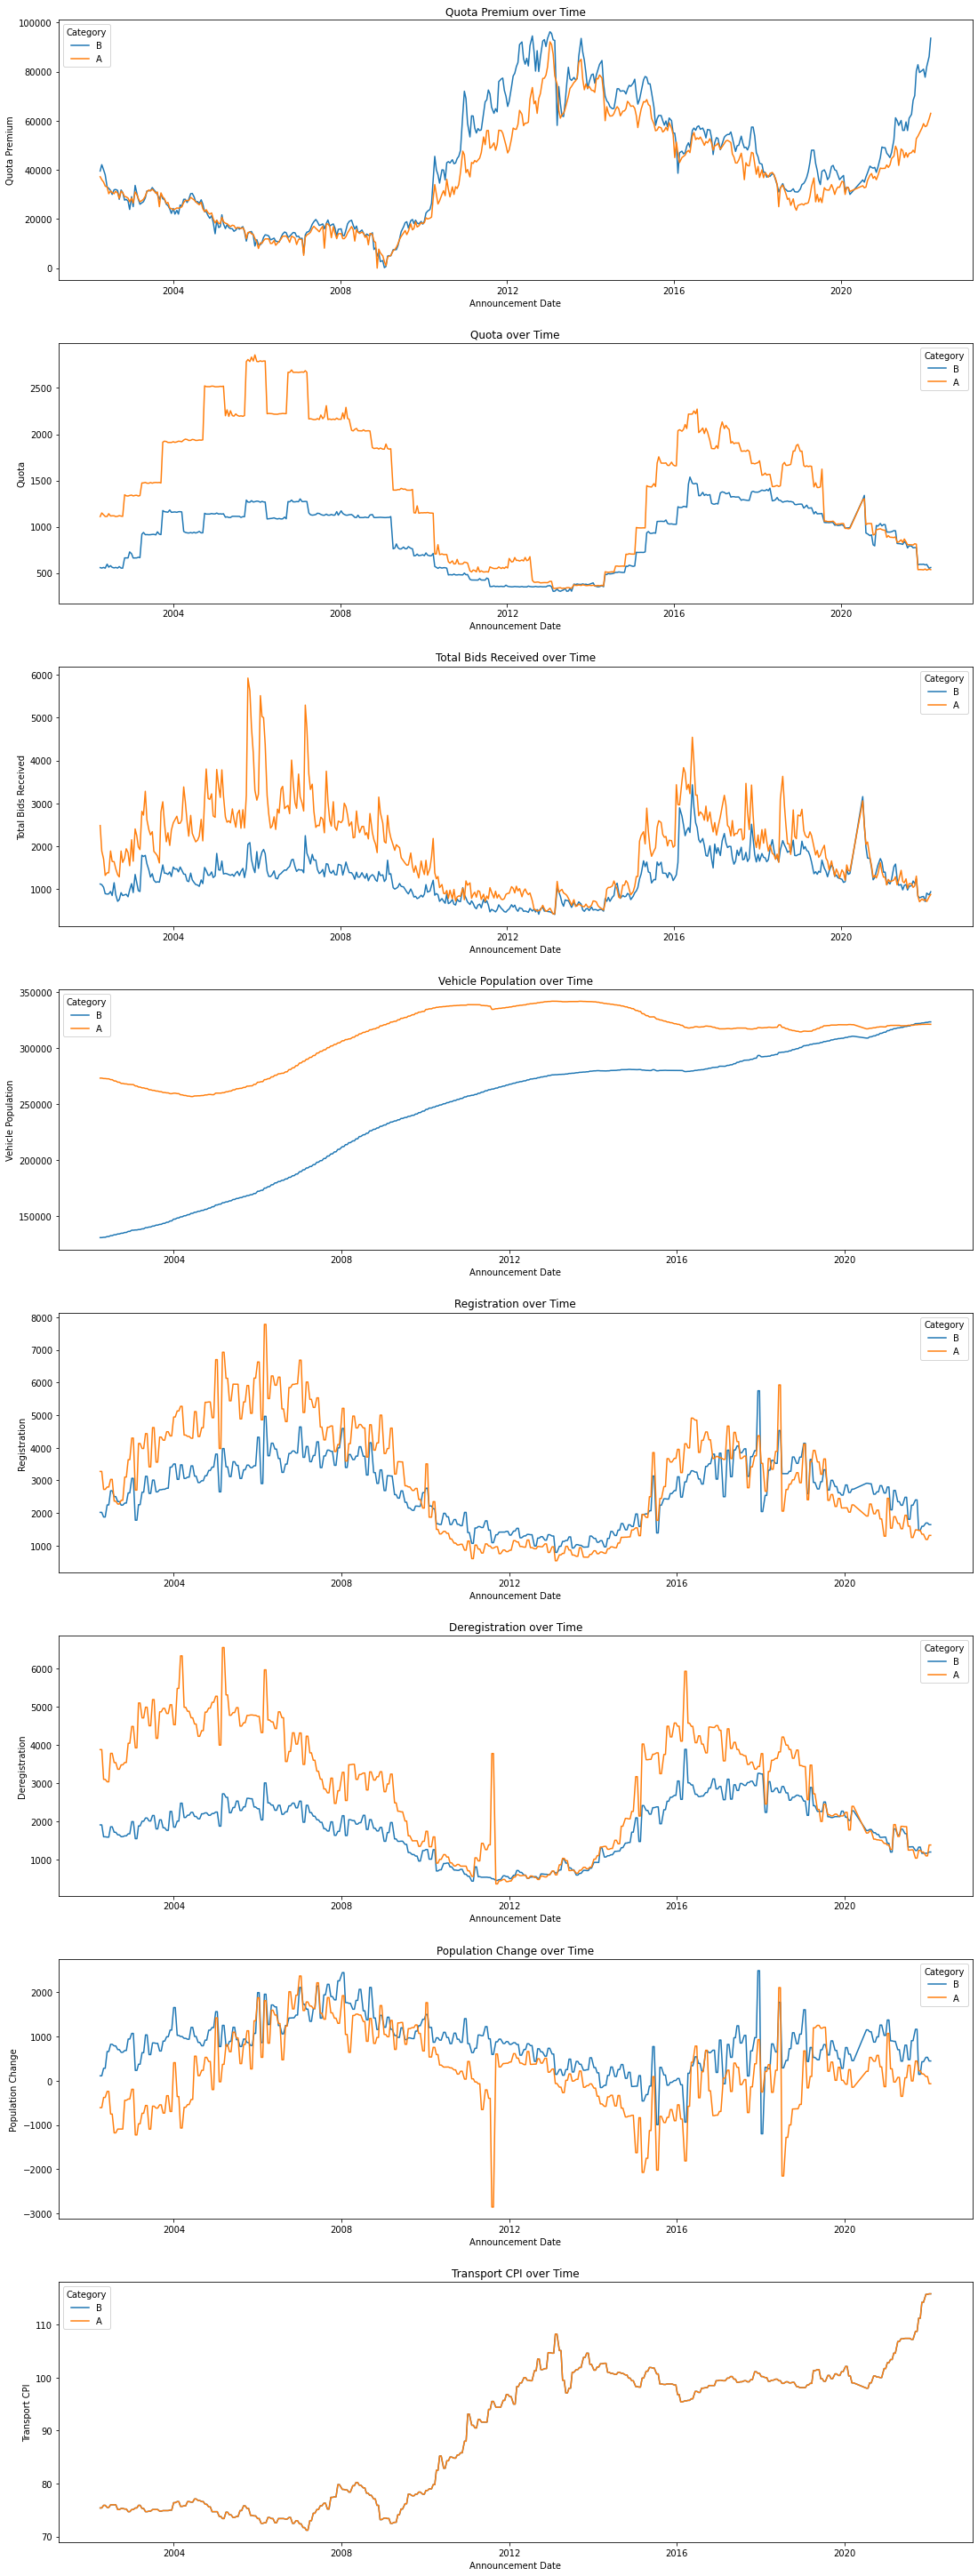

In [6]:
f, ax = plt.subplots(8, 1, figsize=(15, 40))
f.tight_layout(h_pad=5)

sb.lineplot(data=combined_df, x="Announcement Date", y="Quota Premium", hue="Category", ax=ax[0])
sb.lineplot(data=combined_df, x="Announcement Date", y="Quota", hue="Category", ax=ax[1])
sb.lineplot(data=combined_df, x="Announcement Date", y="Total Bids Received", hue="Category", ax=ax[2])
sb.lineplot(data=combined_df, x="Announcement Date", y="Vehicle Population", hue="Category", ax=ax[3])
sb.lineplot(data=combined_df, x="Announcement Date", y="Registration", hue="Category", ax=ax[4])
sb.lineplot(data=combined_df, x="Announcement Date", y="Deregistration", hue="Category", ax=ax[5])
sb.lineplot(data=combined_df, x="Announcement Date", y="Population Change", hue="Category", ax=ax[6])
sb.lineplot(data=combined_df, x="Announcement Date", y="Transport CPI", hue="Category", ax=ax[7])

ax[0].set_title("Quota Premium over Time")
ax[1].set_title("Quota over Time")
ax[2].set_title("Total Bids Received over Time")
ax[3].set_title("Vehicle Population over Time")
ax[4].set_title("Registration over Time")
ax[5].set_title("Deregistration over Time")
ax[6].set_title("Population Change over Time")
ax[7].set_title("Transport CPI over Time")


The above visualization shows the trend of the data across time.

Transport CPI seem to have weak positive correlation with Quota Premium, which can be seen from the common increasing trend from year 2009-2013 and year 2020 onwards

Wheareas several features seem to have weak negative correlation with Quota Premium, which are
1. Quota
2. Total Bids Received
3. Registration
4. Deregistration

When these features are increasing, the Quota Premium is decreasing. 
These negative relations would become more obvious if we compare the Quota Premium trend with the trend of these feature around 2 years back.

For example, Quota Premium is at its local minimum point around year 2009 and 2019, while Quota is at its local maximum point around 2007 and 2017.
Similar pattern are also observed in the case for Total Bids Received, Registration and Deregistration.

Therefore, in the next part of visualization, the features are shifted forward and compared against the original trend of Quota Premium.

### Comparing Quota Premium with time shifted features

In [7]:
def get_time_shifted_data(df: pd.DataFrame,  columns_shifts):
    df = df.copy()
    target_cols = list()

    for col in columns_shifts:
        num_shift = int(columns_shifts[col])
        if num_shift == 0:
            target_cols.append(col)
            continue
        new_col = "{} Lagged {}".format(col, num_shift)
        temp_df = pd.DataFrame({
            "Bidding Timestamp": df["Bidding Timestamp"] + num_shift,
            "Category": df["Category"],
            new_col: df[col]
        })
        df = pd.merge(df, temp_df, how="left", on=["Bidding Timestamp", "Category"])
        target_cols.append(new_col)
    return target_cols, df
    

def plot_time_shifted_data(df: pd.DataFrame, columns_shifts):
    _, time_shifted_data = get_time_shifted_data(combined_df, columns_shifts)
    num_plots = len(columns_shifts)

    f, ax = plt.subplots(num_plots, 1, figsize=(15, 5 * num_plots))
    f.tight_layout(h_pad=5)

    for i, col in enumerate(columns_shifts):
        if columns_shifts[col] == 0:
            sb.lineplot(data=time_shifted_data, x="Announcement Date", y=col, hue="Category", ax=ax[i])
        else:
            sb.lineplot(data=time_shifted_data, x="Announcement Date", y=col, hue="Category", ax=ax[i])
            sb.lineplot(
                data=time_shifted_data, 
                x="Announcement Date", 
                y="{} Lagged {}".format(col, int(columns_shifts[col])),
                linestyle="dashed", 
                alpha=0.5, 
                hue="Category", 
                legend=False,
                ax=ax[i]
            )
        ax[i].set_title("{} shifted {} over Time".format(col, columns_shifts[col]))

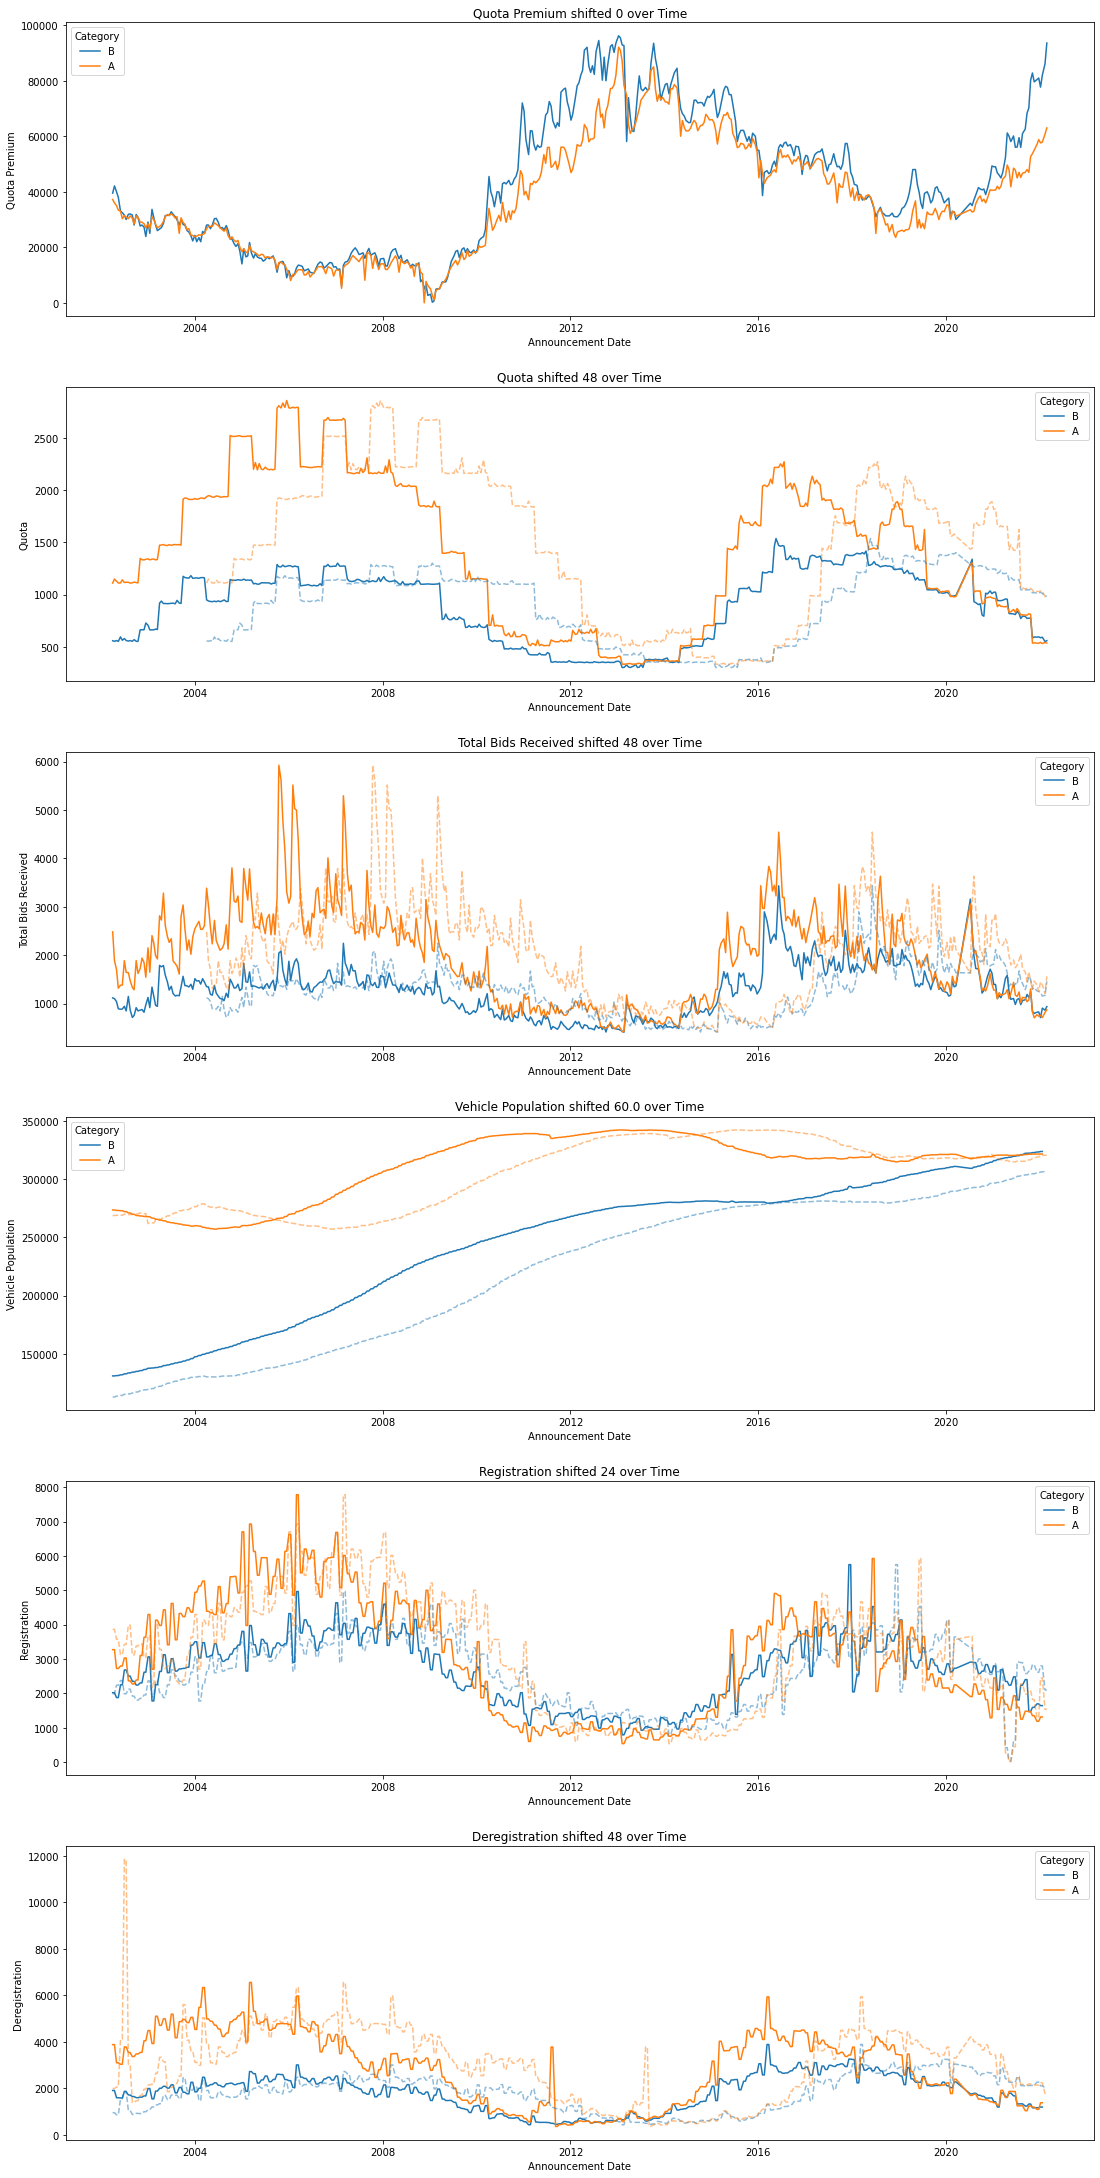

In [8]:
columns_shifts = {
    "Quota Premium": 0, 
    "Quota": 24 * 2, # 2 years back
    "Total Bids Received": 24 * 2, # 2 years back
    "Vehicle Population": 24 * 2.5, # 2.5 years back
    "Registration": 24, # 2 years back
    "Deregistration": 24 * 2, # 2 years back
}

plot_time_shifted_data(combined_df, columns_shifts)


The dotted lines in each graph above show the trend of the features after time shifting.

For the features including Quota, Total Bids Received, Registration and Deregistration, the time shifted graph has clearer opposite trend against Quota Premium, indicating stronger negative correlation after time shifting.

Besides, the Vehicle Population for Cat A shows stronger positive correlation with Quota Premium for Cat A after shifting.

### Correlation between features

To validate the observation above, heatmap is used to visualize the increase in the correlations between various time shifted features and Quota Premium.

In [9]:

def plot_correlation(df: pd.DataFrame, columns_shifts, figsize=(20,16), plot_diff=True):
    target_cols, time_shifted_df = get_time_shifted_data(df, columns_shifts)
    num_rows = 2 if plot_diff else 1
    figsize =  (figsize[0], figsize[1] // 2) if not plot_diff else figsize 

    f, ax = plt.subplots(num_rows, 2, figsize=figsize)
    
    for i, category in enumerate(["A", "B"]):
        sb.heatmap(
            data=time_shifted_df[time_shifted_df["Category"]==category][target_cols].corr().abs(),
            square=True,
            annot=True,
            fmt=".3f",
            ax=ax[0, i] if plot_diff else ax[i],
            cmap="Blues",
            vmin=0,
            vmax=1,
            cbar=False
        )

        if plot_diff:
            ax[0, i].set_title("Category: {}".format(category))
        else:
            ax[i].set_title("Category: {}".format(category))

        if plot_diff:
            difference = pd.DataFrame(
                data=(
                    time_shifted_df[time_shifted_df["Category"]==category][target_cols].corr().abs().values[0]
                    - df[df["Category"]==category][columns_shifts.keys()].corr().abs().values[0]
                ),
                columns=["Quota Premium"],
                index=columns_shifts.keys()
            ).T

            sb.heatmap(
                data=difference,
                square=True,
                annot=True,
                fmt=".3f",
                ax=ax[1, i],
                cmap="coolwarm_r",
                vmin=-0.3,
                vmax=0.3,
                cbar=False
            )
            ax[1, i].set_title("Category: {} Difference in Correlation After Shifting".format(category))
    f.set_facecolor("white")
    return df



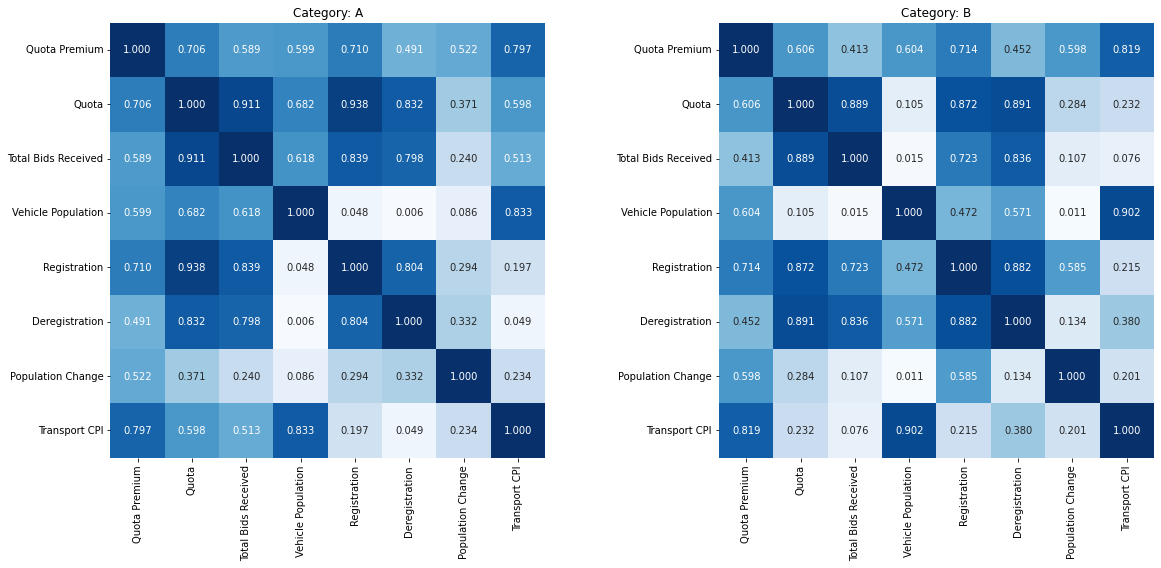

In [10]:
zero_shift = {
    "Quota Premium": 0, 
    "Quota": 0, 
    "Total Bids Received": 0,
    "Vehicle Population": 0, 
    "Registration": 0,
    "Deregistration": 0,
    "Population Change": 0,
    "Transport CPI": 0
}

plot_correlation(combined_df, zero_shift, plot_diff=False)
pass

The above heatmap shows the correlation between the data without time shifting.

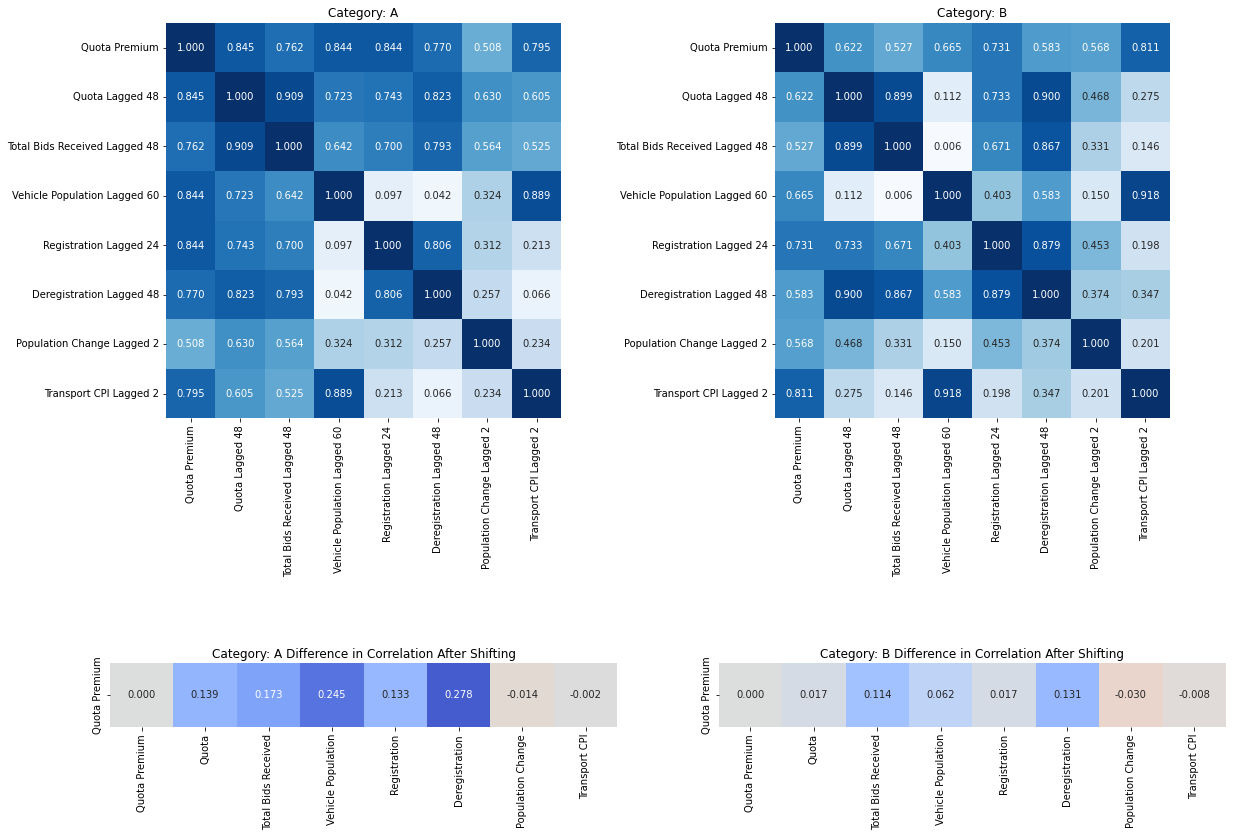

In [11]:
columns_shifts = {
    "Quota Premium": 0, 
    "Quota": 24 * 2, # 2 years back
    "Total Bids Received": 24 * 2, # 2 years back
    "Vehicle Population": 24 * 2.5, # 2.5 years back
    "Registration": 24, # 1 year back
    "Deregistration": 24 * 2, # 2 years back
    "Population Change": 2, # 1 months back
    "Transport CPI": 2 # 1 months back
}

plot_correlation(combined_df, columns_shifts)
pass

From the heatmaps, we can see that after time shifting, there are increase in the correlation between the features and Quota Premium. 

This might imply that the change in the Quota, Total Bids Received, Vehicle Population, Registration and Deregistraion will take some time to have impact on the Quota Premium.

Example:
- Why Quota Premium increases since 2019?

    This may be due to the decrease of the Quota since 2017. It takes around 2 years for the decrease in supply of the COE to cause the increase in Quota Premium around 2019 

The increase of correlation after time shifting is more significant for Cat A.

For Population Change and Transport CPI, we also consider their correlations with Quota Premium after shifting one month forward. This is because during prediction, the latest values that we have for these features are the values from the previous month.
Hence, drop in correlation is expected as the value of the previous month data would be less reflective compared to the data of the same month. However, the drop is not significant.

From the data exploration, we know that time shifting affects the correlation between features with Quota Premium. So, when creating the model to predict COE prices, feature engineering will be done by time shifting the features.

This is due to 2 main reasons:
1. More obvious correlation with Quota Premium observed with time shifted data
2. In actual prediction usecase, when predicting the Quota Premium of the next bidding exercise, the current values of the features like Vehicle Population, Registration, Deregistration and Transport CPI are still unknown. Therefore, the closest that can be used are their previous month value.